# Matrix completion and recommender systems


[MovieLens](movielens.umn.edu) data sets were collected by the [GroupLens Research Project](http://www.grouplens.org/) at the University of Minnesota.

This data set consists of:

- 100000 ratings (1-5) from 943 users on 1682 movies.
- Each user has rated at least 20 movies.

The `movielens.csv` file contains the full dataset. Users and items are numbered consecutively from 1. The data is randomly ordered. This is a tab separated list of

```
user id | item id | rating | timestamp
```


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr

Read the dataset from the `movielens.csv` file.


In [2]:
dataset = pd.read_csv(
    "./movielens.csv",
    sep="\t",
    header=None,
    names=["user_id", "item_id", "rating", "timestamp"],
)
dataset

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


How many movies? How many people? How many ratings?


In [4]:
n_people = np.unique(dataset.user_id).size
n_movies = np.unique(dataset.item_id).size
n_ratings = len(dataset)

print(f"{n_people} people")
print(f"{n_movies} movies")
print(f"{n_ratings} ratings")

943 people
1682 movies
100000 ratings


Shuffle the data (see the function [`np.random.shuffle`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.shuffle.html)).

Because of the timestamp, split to test train gives, old ratings in the beginning and new ratings in the end.


In [6]:
np.random.seed(1)  # for reproducibility

# create indices
idxs = np.arange(n_ratings)
# shuffle indices
np.random.shuffle(idxs)
# reorder data using shuffled indices
rows_dupes = dataset.user_id[idxs]
cols_dupes = dataset.item_id[idxs]
vals = dataset.rating[idxs]

Remove unused `user_id` or `movie_id` from `rows` and `cols`. E.g., if we have a dataset like

```
user id | item id | rating
0       |      1  |     4  
0       |      2  |     5  
3       |      2  |     5  
```
Then we would have two empty rows in the matrix (for user 1 and 2) and one empty column (for movie 0).
```
A = [
  [0 4 5],
  [0 0 0],
  [0 0 0],
  [0 ? 5],
]
```
Thus, we want to remove empty intervals.


In [7]:
_, rows = np.unique(rows_dupes, return_inverse=True)
_, cols = np.unique(cols_dupes, return_inverse=True)

print(rows.min(), rows.max(), n_people)
print(cols.min(), cols.max(), n_movies)

0 942 943
0 1681 1682


Split the dataset into a subset of 80000 training ratings and 20000 testing ratings.


In [8]:
training_data = int(0.8 * n_ratings) # use 80% of the data as training

rows_train = rows[:training_data]
cols_train = cols[:training_data]
vals_train = vals[:training_data]
rows_test = rows[training_data:]
cols_test = cols[training_data:]
vals_test = vals[training_data:]

Let us denote by $\Omega$ the set of pairs $(i,j)$ such that rating of the $i$-th user on the $j$-th movie is available in the training set (similarly, $\Omega_{\text{test}}$ is the set of testing pairs).
Let us denote by $r_{ij}$ the corresponding rating.

Create a full matrix $X \in \mathbb{R}^{n \times p}$, such that:

$$
X_{i,j} =
\begin{cases}
r_{ij} & \text{if } (i,j) \in \Omega\\
0& \text{otherwise}
\end{cases}
$$


In [11]:
# converting to sparse matrix
X_sparse = csr_matrix((vals_train, (rows_train, cols_train)), shape=(n_people, n_movies))
# transforming into full matrix
X_full = X_sparse.toarray()

## Trivial recommender system

Create a trivial recommender system, based on the average rating of each user:

$$
r^{\text{pred}}_{ij} = \frac{1}{N_i} \sum_{j : (i,j) \in \Omega} r_{ij}
$$

where $N_i = card(j : (i,j) \in \Omega)$.
<< For comparison >>

Then compute the RMSE (root mean square error):

$$
\text{RMSE} = \sqrt{\frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}} (r_{ij} - r^{\text{pred}}_{ij})^2}
$$

and the Pearson correlation coefficient $\rho$ (use the function [scipy.stats.pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html)):

$$
\rho =
\frac
{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}}
       (r_{ij} - \overline{r})
       (r^{\text{pred}}_{ij} - \overline{r}^{\text{pred}})
}
{\sqrt{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}}
       (r_{ij} - \overline{r})^2
       }
\sqrt{
    \displaystyle\sum_{(i,j) \in \Omega_{\text{test}}}
       (r^{\text{pred}}_{ij} - \overline{r}^{\text{pred}})^2
       }}
$$

where

$$
\begin{split}
\overline{r} &= \frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}}
       r_{ij}
\\
\overline{r}^{\text{pred}} &= \frac{1}{card(\Omega_{\text{test}})} \sum_{(i,j) \in \Omega_{\text{test}}}
       r^{\text{pred}}_{ij}
\end{split}
$$


In [12]:
#baseline - trivial recommender system
# compute trivial predictor on the training dataset
# FILL HERE

avg_ratings = np.empty((n_people,))
for user_id in range(n_people):
  avg_ratings[user_id] = np.mean(vals_train[rows_train == user_id])
# The vectorized version
# sum_ratings = np.bincount(rows_train, weights=vals_train, minlength=n_people)
# count_ratings = np.bincount(rows_train, minlength=n_people)
# avg_ratings = sum_ratings / count_ratings

# use the trivial predictor on the test dataset
vals_trivial = avg_ratings[rows_test]
# SOLUTION-END
errors_trivial = vals_test - vals_trivial

# print the metrics
RMSE_trivial = np.sqrt(np.mean(errors_trivial**2))
rho_trivial = pearsonr(vals_test, vals_trivial)[0]
print(f"RMSE: {RMSE_trivial:1.3f}")
print(f"rho : {rho_trivial:1.3f}")

RMSE: 1.043
rho : 0.384


Pearson correlation

# Singular value truncation (SVT) based recommender system


Hard thresholding variation of SVT

Implement the SVT algorithm to predict the ratings of the testing set. Set a maximum number of iterations equal to 100. Print the RMSE and $\rho$ at each iteration.

Try to calibrate the threshold to get better results.

Sketch of the SVT steps:
1. $U \Sigma V^T = A$
2. $\displaystyle A = \sum_{k : \sigma_k < \texttt{threshold}} \sigma_k u_k v_k$
3. $A_{ij} = X_{ij}$ for all $i, j$ in the training dataset
4. Compute the difference w.r.t. the $A$ at the previous step
5. Compute and save the test metrics


In [15]:
# Hyperparameters
n_max_iter = 100
threshold = 100.0 #controls rank
increment_tol = 1e-6 #stops when updates becomes negligible

RMSE_list = list()
rho_list = list()

A = X_full.copy()

print("Iter | Increment |  RMSE |  Corr ")
#each iteration refines matrix completion
for i in range(n_max_iter):
# FILL HERE
    A_old = A.copy()

    U,s,VT = np.linalg.svd(A, full_matrices=False)

    # SVT step, implements the condition for being 0 or s
    # Removes weak latent factors
    s[s < threshold] = 0

    # Matrix reconstruction
    A = U @ np.diag(s) @ VT

    # Projection onto observed entries
    A[rows_train,  cols_train] = vals_train

    # Convergence check
    increment = np.linalg.norm(A - A_old)

    # prediction

    vals_predicted = A[rows_test, cols_test]
    errors = vals_test - vals_predicted
    #evaluation matrix

    RMSE_list.append(np.sqrt(np.mean(errors**2)))
    rho_list.append(pearsonr(vals_test, vals_predicted)[0])

    print(f"{i+1:04} | {increment:.3e} | {RMSE_list[-1]:1.3f} | {rho_list[-1]:1.3f}")
    if increment < increment_tol:
        break

Iter | Increment |  RMSE |  Corr 
0001 | 4.308e+02 | 2.611 | 0.314
0002 | 2.581e+02 | 2.166 | 0.342
0003 | 1.843e+02 | 1.919 | 0.364
0004 | 1.433e+02 | 1.758 | 0.381
0005 | 1.171e+02 | 1.645 | 0.395
0006 | 9.887e+01 | 1.561 | 0.407
0007 | 8.547e+01 | 1.495 | 0.417
0008 | 7.521e+01 | 1.443 | 0.426
0009 | 6.711e+01 | 1.400 | 0.433
0010 | 6.056e+01 | 1.364 | 0.440
0011 | 5.516e+01 | 1.334 | 0.445
0012 | 5.063e+01 | 1.308 | 0.451
0013 | 4.678e+01 | 1.285 | 0.455
0014 | 4.347e+01 | 1.265 | 0.460
0015 | 4.059e+01 | 1.248 | 0.464
0016 | 3.807e+01 | 1.233 | 0.467
0017 | 3.584e+01 | 1.219 | 0.471
0018 | 3.385e+01 | 1.206 | 0.474
0019 | 3.208e+01 | 1.195 | 0.477
0020 | 3.047e+01 | 1.185 | 0.479
0021 | 2.902e+01 | 1.175 | 0.482
0022 | 2.771e+01 | 1.167 | 0.484
0023 | 2.650e+01 | 1.159 | 0.486
0024 | 2.540e+01 | 1.152 | 0.488
0025 | 2.438e+01 | 1.145 | 0.490
0026 | 2.344e+01 | 1.139 | 0.492
0027 | 2.257e+01 | 1.133 | 0.494
0028 | 2.177e+01 | 1.128 | 0.495
0029 | 2.102e+01 | 1.123 | 0.497
0030 | 2.

**Homework answers (concise):**

1. **Using rSVD (randomized SVD):**
   It significantly speeds up each iteration because you only approximate the top singular components instead of computing a full SVD. This is especially beneficial for large, sparse rating matrices.

   **Good choice of `k`:**

   * Choose `k` slightly larger than the expected rank of the rating matrix.
   * In practice: **`k ≈ 20–50`** for small datasets (e.g. MovieLens-100k), **`k ≈ 50–100`** for larger ones.
   * Rule of thumb: smallest `k` that gives stable RMSE.

2. **Quicker way to apply the threshold (singular value thresholding):**
   Do **soft-thresholding** directly on singular values and keep only those above the threshold:

   * Discard singular values `< threshold`
   * Reconstruct using only the remaining components

   This avoids forming `diag(s)` full of zeros and unnecessary matrix multiplications.

   Mathematically:
   [
   s_i \leftarrow \max(s_i - \tau, 0)
   ]
   and reconstruct using only non-zero singular values.


Plot the history of RMSE and $\rho$ and confront it with the trivial predictor

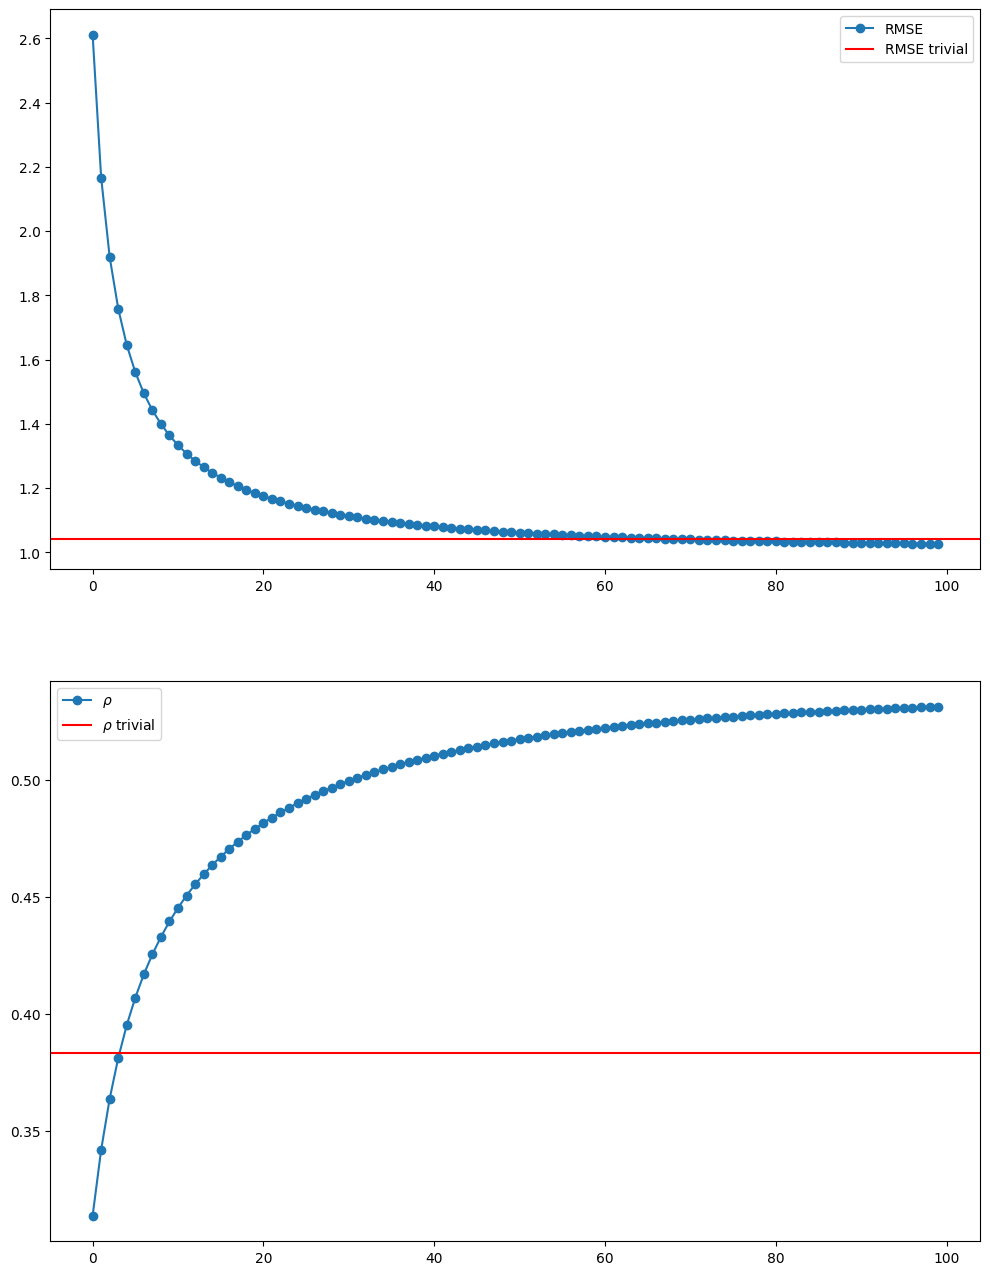

In [16]:
# FILL HERE
# SOLUTION-BEGIN
fig, axs = plt.subplots(2, 1, figsize=(12, 16))

axs[0].plot(RMSE_list, "o-")
axs[0].axhline(RMSE_trivial, color="red")
axs[0].legend(["RMSE", "RMSE trivial"])

axs[1].plot(rho_list, "o-")
axs[1].axhline(rho_trivial, color="red")
axs[1].legend([r"$\rho$", r"$\rho$ trivial"])